https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

# Video Classification - HOT or NOT

### Import stuff

In [1]:

# Check the versions of libraries
 
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))


# Import more stuff
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sb
import os
import datetime as dt
import random as rd

Python: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
scipy: 1.5.0
numpy: 1.18.5
matplotlib: 3.2.2
pandas: 1.0.5
sklearn: 0.23.1


### Import Data

In [2]:
path_folder = r"..\\data\\"

df_vc = pd.read_csv(path_folder+'video_count.csv')#.set_index('video_id')
df_vf = pd.read_csv(path_folder+'video_features.csv')#.set_index('video_id')

# Convert Quality Value for str to int
df_vf['video_quality'] = df_vf['video_quality'].apply(lambda x: int(x[:-1]))

df_vf.head(3)

,video_id,video_length,video_language,video_upload_date,video_quality
0,1,16,chineese,11/09/2017,480
1,2,27,spanish,03/10/2017,480
2,3,30,spanish,06/10/2017,240


### Clean and format

In [3]:
# Convert str into datetime type
df_vc['date'] = pd.to_datetime(df_vc.date, format='%d/%m/%Y')
df_vf['video_upload_date'] = pd.to_datetime(df_vf.video_upload_date)

# Create Calculated Columns
df_vc['week_start_date'] = df_vc.date - pd.to_timedelta((df_vc['date'].dt.dayofweek + 1) % 7, unit='d')

df_vc.head()

,video_id,date,count,CLASS,week_start_date
0,3,2018-01-27,6,-1.0,2018-01-21
1,3,2018-02-01,6,-1.0,2018-01-28
2,3,2018-01-31,6,-1.0,2018-01-28
3,3,2018-01-25,7,-1.0,2018-01-21
4,3,2018-02-03,7,-1.0,2018-01-28


### Merge Features with Count Data

In [8]:
# Merge
df_joined = df_vc.merge(df_vf, left_on='video_id', right_on='video_id', how='left')

# Create Calculated Columns
df_joined['days_from_upload'] = df_joined.date - df_joined.video_upload_date
df_joined['days_from_upload'] = df_joined['days_from_upload'].apply(lambda x: int(x.days))

# Sort
df_joined.sort_values('date')

print(df_joined.dtypes)
df_joined.head()

video_id                      int64
date                 datetime64[ns]
count                         int64
CLASS                       float64
week_start_date      datetime64[ns]
video_length                  int64
video_language               object
video_upload_date    datetime64[ns]
video_quality                 int64
days_from_upload              int64
dtype: object


,video_id,date,count,CLASS,week_start_date,video_length,video_language,video_upload_date,video_quality,days_from_upload
0,3,2018-01-27,6,-1.0,2018-01-21,30,spanish,2017-06-10,240,231
1,3,2018-02-01,6,-1.0,2018-01-28,30,spanish,2017-06-10,240,236
2,3,2018-01-31,6,-1.0,2018-01-28,30,spanish,2017-06-10,240,235
3,3,2018-01-25,7,-1.0,2018-01-21,30,spanish,2017-06-10,240,229
4,3,2018-02-03,7,-1.0,2018-01-28,30,spanish,2017-06-10,240,238


### Calculate Weekly AVG

In [4]:
df_wk_avg = df_joined[['week_start_date', 'count']].groupby('week_start_date')['count'].mean()
df_wk_avg.head(3)

week_start_date
2017-09-03    101.064516
2017-09-10    100.981982
2017-09-17    101.383886
Name: count, dtype: float64

### Append Weekly AVGs to Main Dataframe

In [5]:
df_joined_with_avg = df_joined.join(df_wk_avg, on='week_start_date', rsuffix='_week_AVG')

# Create Calculated Column: Difference from WAVG
df_joined_with_avg['Avg_Offset'] = df_joined_with_avg['count'] - df_joined_with_avg.count_week_AVG.apply(lambda x: int(x))
df_joined_with_avg.head(3)

,video_id,date,count,CLASS,video_length,video_language,video_upload_date,video_quality,week_start_date,days_from_upload,count_week_AVG,Avg_Offset
0,3,2018-01-27,6,-1.0,30,spanish,2017-06-10,240,2018-01-21,231,55.857494,-49
1,3,2018-02-01,6,-1.0,30,spanish,2017-06-10,240,2018-01-28,236,54.736677,-48
2,3,2018-01-31,6,-1.0,30,spanish,2017-06-10,240,2018-01-28,235,54.736677,-48


### Encode non-numeric Dimentions

In [6]:
encode = ['video_language']

df_with_dummies = df_joined_with_avg
dum_cols = []
for col in encode:
    dummy = pd.get_dummies(df_joined_with_avg[col], prefix=col)
    dum_cols += list(dummy.columns)
    df_with_dummies = pd.concat([df_with_dummies,dummy], axis=1)
    del df_with_dummies[col]

df_with_dummies.head(3)


,video_id,date,count,CLASS,video_length,video_upload_date,video_quality,week_start_date,days_from_upload,count_week_AVG,Avg_Offset,video_language_chineese,video_language_english,video_language_spanish
0,3,2018-01-27,6,-1.0,30,2017-06-10,240,2018-01-21,231,55.857494,-49,0,0,1
1,3,2018-02-01,6,-1.0,30,2017-06-10,240,2018-01-28,236,54.736677,-48,0,0,1
2,3,2018-01-31,6,-1.0,30,2017-06-10,240,2018-01-28,235,54.736677,-48,0,0,1


### Determine Prediction Target Dim and Features Dims

In [21]:
target_col_name = 'CLASS'    
cols = ['video_length', 'video_quality', 'days_from_upload', 'Avg_Offset'] + dum_cols
df_test = df_with_dummies[df_with_dummies['CLASS'] > -2][cols + [target_col_name]]
df_test.head()

,video_length,video_quality,days_from_upload,Avg_Offset,video_language_chineese,video_language_english,video_language_spanish,CLASS
0,30,240,231,-49,0,0,1,-1.0
1,30,240,236,-48,0,0,1,-1.0
2,30,240,235,-48,0,0,1,-1.0
3,30,240,229,-48,0,0,1,-1.0
4,30,240,238,-47,0,0,1,-1.0


### Display distribution of DF Dimentions by Boxplots

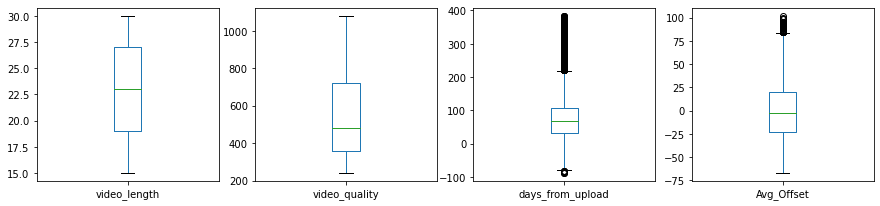

In [22]:

df_with_dummies[cols].drop(columns=dum_cols).plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(15,7))
plt.show()

### Split dataset to train and validation

In [23]:
X = df_test.drop(columns=target_col_name).values
y = df_test[target_col_name].values
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=1)
print('Train size      :', len(X_train))
print('Validation size :', len(X_validation))
print(X_train[1])

Train size      : 3000
Validation size : 1000
[ 26 240  58 -46   0   0   1]


### Fit into Random Forest Model

In [24]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_validation)

# Test the model's accuracy
score = accuracy_score(Y_validation, Y_pred)
print("Model's Accuracy Score:", score)

Model's Accuracy Score: 0.992


### Display Model's Accuracy as a Matrix

In [25]:
lbls = list(df_test[target_col_name].unique())
cm = confusion_matrix(Y_validation, Y_pred, labels=lbls)
cm

array([[522,   3,   0],
       [  5, 243,   0],
       [  0,   0, 227]], dtype=int64)

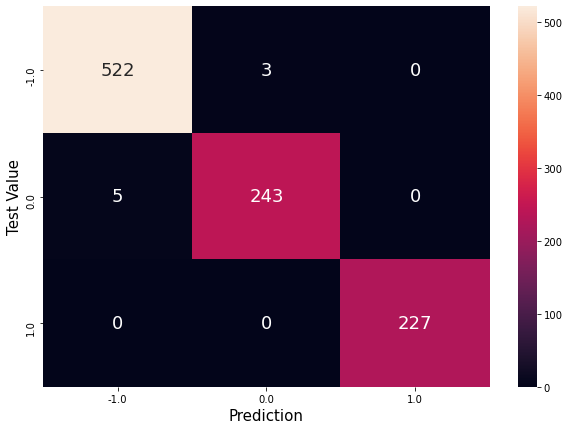

In [26]:
%matplotlib inline
plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='g', annot_kws={"fontsize":18}, xticklabels=lbls, yticklabels=lbls)
plt.xlabel('Prediction', size=15)
plt.ylabel('Test Value', size=15)
plt.show()

### Single Testing

In [147]:
# Using input
# data_to_test = np.array([int(input(x+': ')) for x in cols]).reshape(1, -1)

# Manually
print(df_test.loc[0])
data_to_test = np.array([18, 1080, 300, 0, 1, 0]).reshape(1, -1)

video_length                30.0
video_quality              240.0
days_from_upload           231.0
video_language_chineese      0.0
video_language_english       0.0
video_language_spanish       1.0
CLASS                       -1.0
Name: 0, dtype: float64


In [148]:
clf.predict(data_to_test)

array([0.])

# Second Approach - Weekly Agg

In [4]:
df_weekly = df_vc.groupby(['week_start_date', 'video_id'])['count'].sum()
df_weekly = pd.DataFrame(df_weekly).reset_index()
print(df_weekly.shape)
df_weekly.head()

(1813, 3)


,week_start_date,video_id,count
0,2017-09-03,13,736
1,2017-09-03,16,260
2,2017-09-03,32,177
3,2017-09-03,70,838
4,2017-09-03,73,538


In [5]:
# Merge
df_weekly_joined = df_weekly.merge(df_vf, left_on='video_id', right_on='video_id', how='left')

# Create Calculated Columns
df_weekly_joined['days_from_upload'] = df_weekly_joined.week_start_date - df_weekly_joined.video_upload_date
df_weekly_joined['days_from_upload'] = df_weekly_joined['days_from_upload'].apply(lambda x: int(x.days))

# Sort
df_weekly_joined.sort_values('week_start_date')

print(df_weekly_joined.dtypes)
df_weekly_joined.head()

week_start_date      datetime64[ns]
video_id                      int64
count                         int64
video_length                  int64
video_language               object
video_upload_date    datetime64[ns]
video_quality                 int64
days_from_upload              int64
dtype: object


,week_start_date,video_id,count,video_length,video_language,video_upload_date,video_quality,days_from_upload
0,2017-09-03,13,736,18,english,2017-03-09,720,178
1,2017-09-03,16,260,24,spanish,2017-08-09,1080,25
2,2017-09-03,32,177,29,english,2017-07-09,240,56
3,2017-09-03,70,838,18,english,2017-03-09,480,178
4,2017-09-03,73,538,25,chineese,2017-03-09,480,178


### Calculate Weekly AVG

In [6]:
df_wk_avg = df_weekly_joined[['week_start_date', 'count']].groupby('week_start_date')['count'].mean()
df_wk_avg.head(3)

week_start_date
2017-09-03    391.625000
2017-09-10    487.347826
2017-09-17    578.162162
Name: count, dtype: float64

### Append Weekly AVGs to Main Dataframe

In [7]:
df_joined_with_avg = df_weekly_joined.join(df_wk_avg, on='week_start_date', rsuffix='_week_AVG')

# Create Calculated Column: Difference from WAVG
df_joined_with_avg['Avg_Offset'] = df_joined_with_avg['count'] - df_joined_with_avg.count_week_AVG.apply(lambda x: int(x))
df_joined_with_avg.head(3)

,week_start_date,video_id,count,video_length,video_language,video_upload_date,video_quality,days_from_upload,count_week_AVG,Avg_Offset
0,2017-09-03,13,736,18,english,2017-03-09,720,178,391.625,345
1,2017-09-03,16,260,24,spanish,2017-08-09,1080,25,391.625,-131
2,2017-09-03,32,177,29,english,2017-07-09,240,56,391.625,-214


### Encode non-numeric Dimentions

In [8]:
encode = ['video_language']

df_with_dummies = df_joined_with_avg
dum_cols = []
for col in encode:
    dummy = pd.get_dummies(df_joined_with_avg[col], prefix=col)
    dum_cols += list(dummy.columns)
    df_with_dummies = pd.concat([df_with_dummies,dummy], axis=1)
    del df_with_dummies[col]

df_joined_with_avg.to_excel(path_folder+'df before class.xlsx', index=False)
df_with_dummies.head(3)


,week_start_date,video_id,count,video_length,video_upload_date,video_quality,days_from_upload,count_week_AVG,Avg_Offset,video_language_chineese,video_language_english,video_language_spanish
0,2017-09-03,13,736,18,2017-03-09,720,178,391.625,345,0,1,0
1,2017-09-03,16,260,24,2017-08-09,1080,25,391.625,-131,0,0,1
2,2017-09-03,32,177,29,2017-07-09,240,56,391.625,-214,0,1,0


### Determine Prediction Target Dim and Features Dims

In [33]:
target_col_name = 'CLASS'    
cols = ['video_length', 'video_quality', 'days_from_upload', 'Avg_Offset'] + dum_cols
df_test = df_with_dummies[df_with_dummies['CLASS'] > -2][cols + [target_col_name]]
df_test.head()

KeyError: 'CLASS'

### Display distribution of DF Dimentions by Boxplots

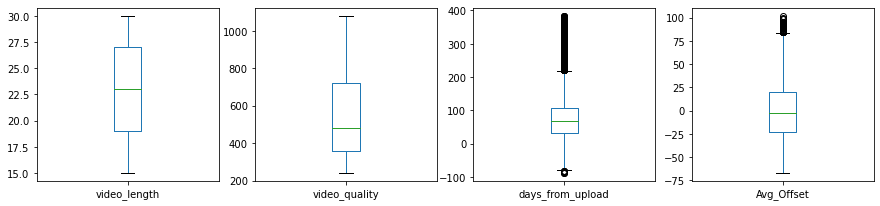

In [22]:

df_with_dummies[cols].drop(columns=dum_cols).plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(15,7))
plt.show()

### Split dataset to train and validation

In [23]:
X = df_test.drop(columns=target_col_name).values
y = df_test[target_col_name].values
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=1)
print('Train size      :', len(X_train))
print('Validation size :', len(X_validation))
print(X_train[1])

Train size      : 3000
Validation size : 1000
[ 26 240  58 -46   0   0   1]


### Fit into Random Forest Model

In [24]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_validation)

# Test the model's accuracy
score = accuracy_score(Y_validation, Y_pred)
print("Model's Accuracy Score:", score)

Model's Accuracy Score: 0.992


### Display Model's Accuracy as a Matrix

In [25]:
lbls = list(df_test[target_col_name].unique())
cm = confusion_matrix(Y_validation, Y_pred, labels=lbls)
cm

array([[522,   3,   0],
       [  5, 243,   0],
       [  0,   0, 227]], dtype=int64)

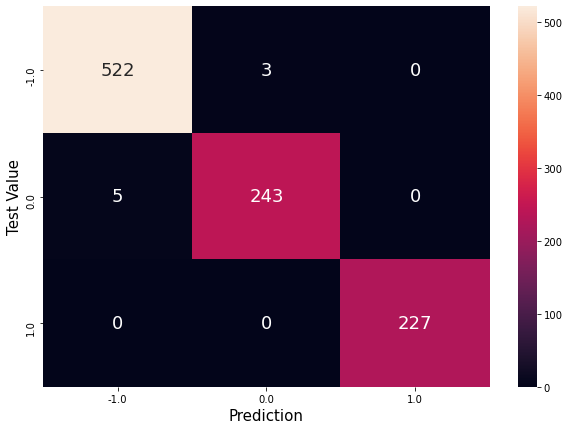

In [26]:
%matplotlib inline
plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='g', annot_kws={"fontsize":18}, xticklabels=lbls, yticklabels=lbls)
plt.xlabel('Prediction', size=15)
plt.ylabel('Test Value', size=15)
plt.show()